# A little experiment with Reddit and statsmodels
---

The other notebooks in this folder are a bit cluttered, so this is meant to streamline my thinking process a bit. Hey Jen 👋

###### Note: I used statsmodels instead of sklearn here, since it's not a particularly big dataset, only about 250k rows

## What's going on here?
---
The data scraper is pretty messy and I haven't looked at it in about half a year, but long story short it collects post metadata pseudo-asynchronously (true async may or may not be better and would definitely take a lot of time to implement) at certain intervals, and logs them at each interval along with a timestamp. These values are (see ../src/config.py):

```
Post attributes: 
['id',
'num_comments',
'title',
'selftext',
'author',
'created_utc',
'score',
'upvote_ratio',
'edited',

'stickied',
'locked']

Subreddit attributes:
['active_user_count',
'subscribers']

Other attributes:

['time_now',        # Current time
'pickup_no',        # which iteration of the scraper?
'post_pickup']      # when was this post first found?
```

So now we're going to do some data regression. First, the setup:

In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

import sys, os
sys.path.append(os.path.abspath('../src'))
import config  # Big config file with preset values

df = pd.read_csv("../datafile_final.csv")  # Our csv file is now a dataframe
pickups = config.POST_PICKUPS


def score(row):  # Gets the net score of the post
    return row["ups"]-row["downs"]

df['score'] = df.apply(score, axis=1)  # Adds score as a new row


# How long have we waited to get this data?
def pickup_time(row):
    return row['time_now'] - row['post_pickup']

df['pickup_time'] = df.apply(pickup_time, axis=1)


# Same thing for title length - makes things easier
def title_length(row):
    return len(row['title'])

df['post_length']=df.apply(title_length, axis=1)

And now our data is in a nice format.

In [60]:
df.head()

,id,num_comments,title,author,created_utc,ups,downs,edited,stickied,locked,active_user_count,subscribers,time_now,pickup_no,post_pickup,score,pickup_time,post_length,created_time
0,audvaw,0,What is the worst thing you ever bought?,mozammel1,1.551050e+09,1,0,False,False,False,207256,21665422,1.551050e+09,0,1.551050e+09,1,1.192093e-06,40,23
1,audvam,0,Which is a favourite song of yours growing up?,hitaccount,1.551050e+09,1,0,False,False,False,207256,21665422,1.551050e+09,0,1.551050e+09,1,4.768372e-07,46,23
2,audv9a,0,What subreddit would be good for promoting fre...,HorseReader,1.551050e+09,1,0,False,False,False,207256,21665422,1.551050e+09,0,1.551050e+09,1,1.192093e-06,59,23
3,audv66,2,What is better Pepsi or Coca-cola?,XxBarnyardManxX,1.551050e+09,1,0,False,False,False,207256,21665422,1.551050e+09,0,1.551050e+09,1,9.536743e-07,34,23
4,audv65,0,"Reddit, what's your side-hustle?",copypasteme,1.551050e+09,1,0,False,False,False,207256,21665422,1.551050e+09,0,1.551050e+09,1,7.152557e-07,32,23


What now? Well, let's do some basic regression with this data.

For example, let's look at the expected change in value between pickups 10 and 15 (waited about 2 days vs 9 days respectively). Of course, posts that haven't been seen by anyone (low # of upvotes) are gonna skew our data, so let's remove those too:

In [53]:
pickup1 = 10
pickup2 = 15

df1 = df.loc[df['pickup_no'] == pickup1][['id','score']]
df2 = df.loc[df['pickup_no'] == pickup2][['id','score']]
df3 = df1.merge(df2,on='id')

df3.drop(df3[df3['score_x']<500].index, inplace=True)

result = sm.ols(formula="score_y ~ score_x", data=df3).fit()
result.params

Intercept    516.465509
score_x        1.108019
dtype: float64

And there we go! Let's visualize this a little bit:

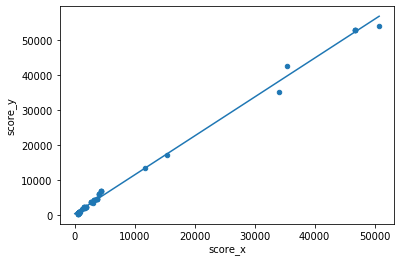

In [54]:
ax=df3.plot(x='score_x', y='score_y',kind='scatter')
linerange = np.arange(1, df3['score_x'].max())
ax.plot(linerange, result.params.Intercept + result.params.score_x * linerange)

This tells us that posts trend generally upwards by 12% as time goes on. This isn't really a good approximation for the success of a post, though, since there's so much noise near the bottom. If over 500 upvotes is success, only 1 out of ~1250 posts succeeds. So this doesn't really help us.

Let's try to fix that.

## Finding posts that will succeed (not really regression)
---
Timezones are weird. Most of Reddit's users live in America though; the exact timezone won't effect our regression, since we use UNIX timestamps, but the fact that the majority is concentrated in a spot should skew it enough for us.

We should expect to see more than just 1/2 peaks in score, though, accounting for Europe, etc — and they might be in a weird spot.

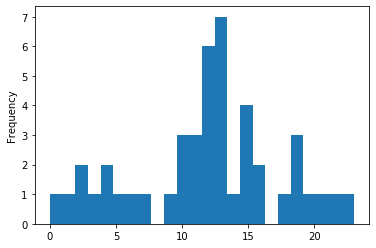

In [59]:
from datetime import datetime

def time(row):
    return datetime.utcfromtimestamp(row['created_utc']).hour
df['created_time']=df.apply(time, axis=1)

# Get the last seen values of each post
df4=df.sort_values('pickup_no', ascending=False).drop_duplicates(subset=['id']).sort_index().reset_index(drop=True)
df4.drop(df4[df4['score']<500].index)['created_time'].plot.hist(bins=24)

Now this is useful! We can see that peak frequency for front-page posts is around 6-7 am PST, with another peak at around 9. This makes sense — people are leaving for work, and they're checking Reddit as they get up in the morning.

One more example - post title length. Do people lose interest when looking at a long title?

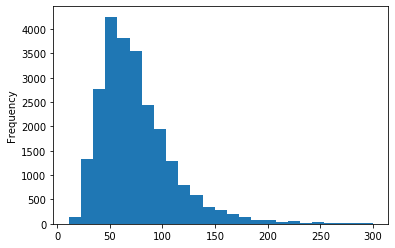

In [71]:
df4['post_length'].plot.hist(bins=25)

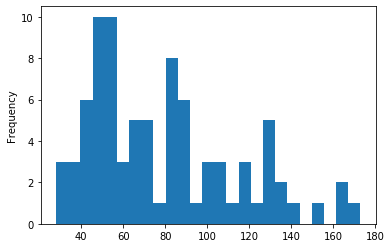

In [74]:
df4.drop(df4[df4['score']<150].index)['post_length'].plot.hist(bins=25)

Apparently, not really. We can't do much with this.

## What next?
---

- Image analysis
- Multivariable analysis
- Real-world testing
- More analysis
    - Using different aspects of metadata
    - Pitting different variables
- Using sklearn, etc: more powerful?
- More data!
- Different subreddits
- User variables
- and more